# Setup

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path

In [4]:
report_output_root_dir = Path('../output/txt')

report_output_dirs = {'gtzan_multi': report_output_root_dir / 'gtzan_multi',
                      'fma_small_multi': report_output_root_dir / 'fma_small_multi',
                      'fma_medium_multi': report_output_root_dir / 'fma_medium_multi',
                      
                      'gtzan_binary': report_output_root_dir / 'gtzan_binary',
                      'fma_small_binary': report_output_root_dir / 'fma_small_binary',
                      'fma_medium_binary': report_output_root_dir / 'fma_medium_binary'}

In [5]:
gtzan_classes = ['Blues', 'Classical', 'Country', 'Disco', 'Hip-Hop', 'Jazz', 'Metal', 'Pop', 'Reggae', 'Rock'] #10

fma_small_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock'] #8

fma_medium_top_classes = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock',
                          'Easy Listening', 'Blues', 'Soul-RnB', 'Spoken', 'Country', 'Jazz', 'Old-Time / Historic', 'Classical'] #16

In [6]:
single_multi_metrics = ['macro_accuracy', 'micro_accuracy',
                        'macro_f1', 'micro_f1',
                        'macro_precision', 'micro_precision',
                        'macro_recall', 'micro_recall',
                        "Cohen's Kappa", 'MCC',
                        'MSE', 'LogLoss',
                        'AUNu', 'AUNp', 'AU1u', 'AU1p']

In [7]:
single_binary_metrics = ['accuracy', 'f1',
                         'precision', 'recall',
                         "cohen's kappa", 'MCC',
                         'MSE', 'LogLoss',
                         'binary_ROC-AUC']

# Helpers

In [8]:
def remove_range(list, elements_to_be_removed):
    for element in elements_to_be_removed:
        list.remove(element)

## Data

In [9]:
def get_sorted_report_dicts_for_model(base_dir, model_name):
    model_dir = base_dir / model_name
    model_subdirs = [x for x in model_dir.iterdir() if x.is_dir()]
    model_reports = [x / '1.json' for x in model_subdirs]
    model_report_dicts = [json.load(open(x)) for x in model_reports]
    model_report_dicts.sort(key=lambda x: x['epochs'])
    return model_report_dicts

In [10]:
def get_min_max_epochs(model_reports):
    min_epochs = model_reports[0]['epochs']
    max_epochs = model_reports[-1]['epochs']
    return min_epochs, max_epochs

In [11]:
class experiment_info:
    def __init__(self, model_name, dataset_name, classification_type, test_set, class_names):
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.classification_type = classification_type
        self.test_set = test_set
        self.class_names = class_names

In [12]:
def get_experiment_info(model_reports, class_names):
    model_name = model_reports['model name']
    dataset_name = model_reports['dataset name']
    classification_type = model_reports['classification type']
    test_set = model_reports['test set']
    class_names = class_names
    return experiment_info(model_name, dataset_name, classification_type, test_set, class_names)

In [13]:
def check_if_same_in_every_epoch(model_reports, metric_name1, metric_name2):
    metric1_values = [x['metrics'][metric_name1] for x in model_reports]
    metric2_values = [x['metrics'][metric_name2] for x in model_reports]
    return all(metric1_values[i] == metric2_values[i] for i in range(len(metric1_values)))

In [38]:
def find_biggest_difference(model_reports, metric_name1, metric_name2):
    metric1_values = [x['metrics'][metric_name1] for x in model_reports]
    metric2_values = [x['metrics'][metric_name2] for x in model_reports]
    differences = [abs(metric1_values[i] - metric2_values[i]) for i in range(len(metric1_values))]
    max_difference = max(differences)
    max_index = differences.index(max_difference)
    return max_difference, model_reports[max_index]['epochs']

## Drawing

In [14]:
def draw_plots_for_model(ax, metrics, model_reports):
    epochs = [x['epochs'] for x in model_reports]
    
    for metric in metrics:
        metric_values = [x['metrics'][metric] for x in model_reports]
        sns.lineplot(x=epochs, y=metric_values, marker='o', label=metric, ax=ax)

In [26]:
def draw_figure_for_model(experiment_info, metrics, reports):
    dataset_description = f"{experiment_info.dataset_name} {experiment_info.classification_type}"
    model_description = f"{experiment_info.model_name}, {dataset_description}, {experiment_info.test_set}"
    
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    
    draw_plots_for_model(ax, metrics, reports)
    
    ax.legend()
    ax.set_xlabel('epochs')
    ax.set_ylabel('metric value')
    ax.set_title(model_description)
    
    plt.show()

## Combined

In [41]:
def draw_figures_for_multi_model(base_dir, model_name, classes, metrics):
    model_reports = get_sorted_report_dicts_for_model(base_dir, model_name)
    model_exp_info = get_experiment_info(model_reports[0], classes)
    
    # first figure (most metrics)
    metrics_fig1 = metrics.copy()
    omitted_metrics = ['MSE', 'LogLoss', 'AUNp', 'AU1u', 'AU1p']
    remove_range(metrics_fig1, omitted_metrics) 
    draw_figure_for_model(model_exp_info, metrics_fig1, model_reports)
    
    # second figure (LogLoss)
    draw_figure_for_model(model_exp_info, ['LogLoss'], model_reports)
    
    # third figure (MSE)
    draw_figure_for_model(model_exp_info, ['MSE'], model_reports)
    
    # macro vs micro
    macro_micro_metrics = { 'accuracy': {'macro_accuracy', 'micro_accuracy'},
                            'f1': {'macro_f1', 'micro_f1'},
                            'precision': {'macro_precision', 'micro_precision'},
                            'recall': {'macro_recall', 'micro_recall'}}
    
    for metric, macro_micro in macro_micro_metrics.items():
        (macro, micro) = macro_micro
        is_same = check_if_same_in_every_epoch(model_reports, *macro_micro)
        print(f"{macro} is same as {micro} in every epoch: {is_same}")
        
        if not is_same:
            max_dif, epoch_max_dif = find_biggest_difference(model_reports, *macro_micro)
            print(f'Biggest difference: {max_dif} in epoch {epoch_max_dif}')
        
        draw_figure_for_model(model_exp_info, [*macro_micro], model_reports)

# GTZAN multi

In [18]:
gtzan_multi_output_dir = report_output_dirs['gtzan_multi']

## Model4_5_spacing

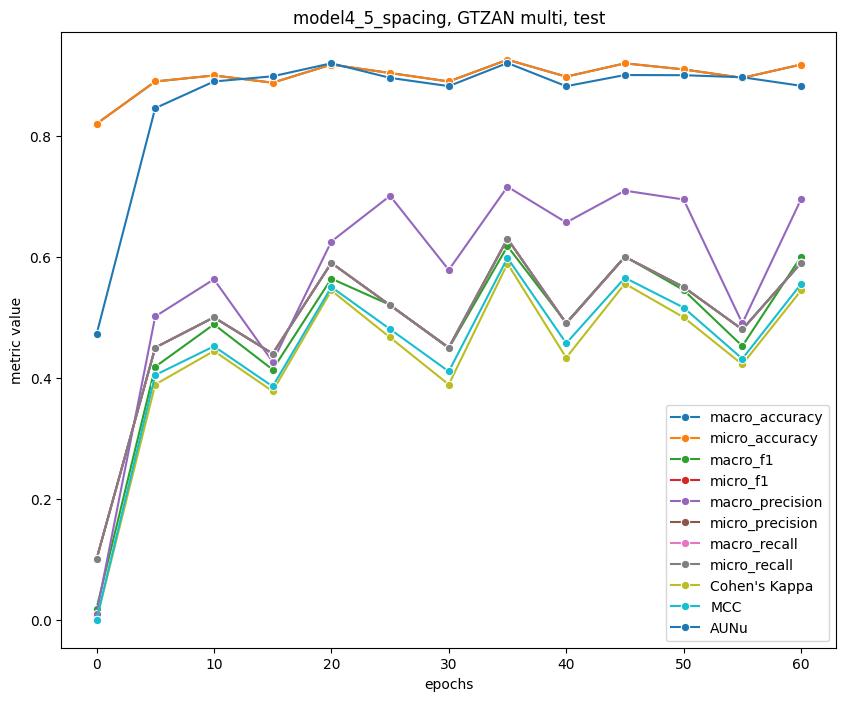

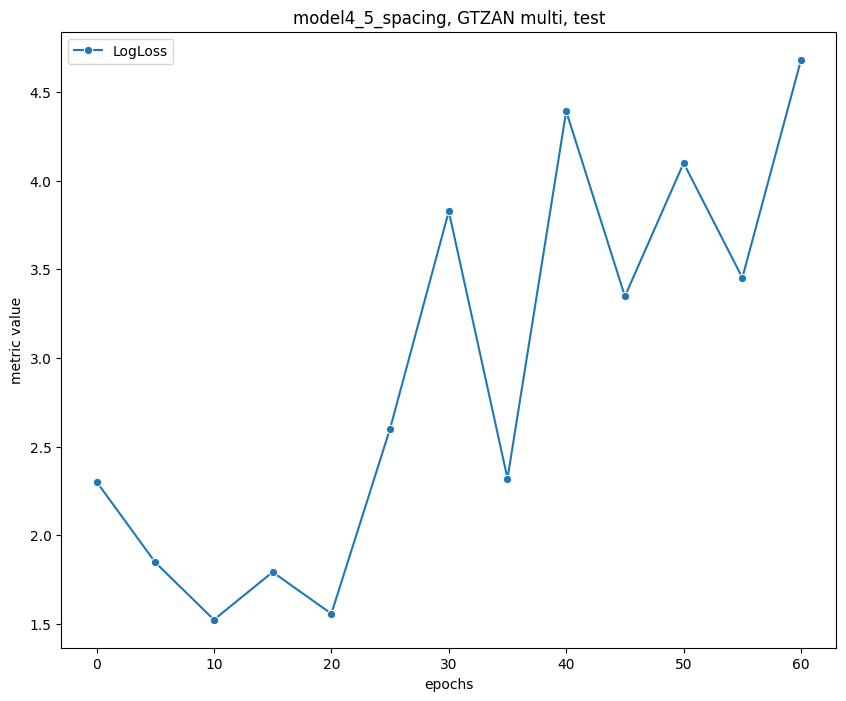

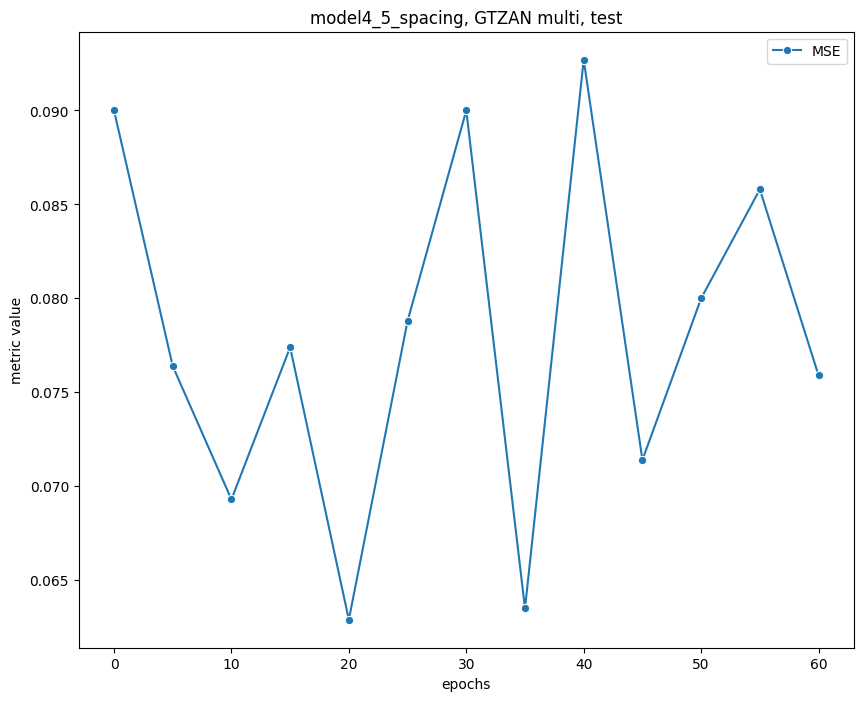

macro_accuracy is same as micro_accuracy in every epoch: True


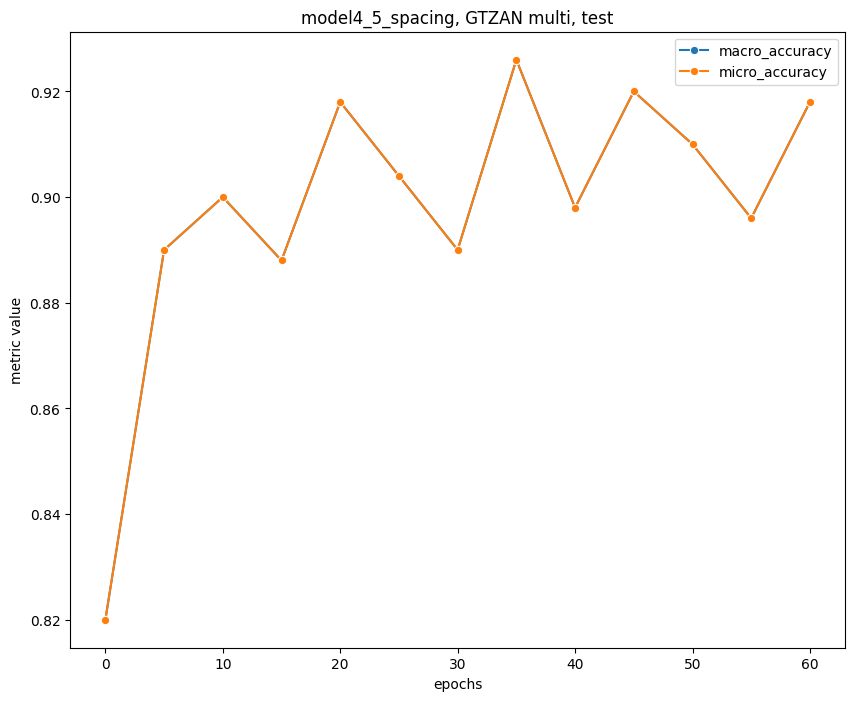

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.08180000000000001 in epoch 0


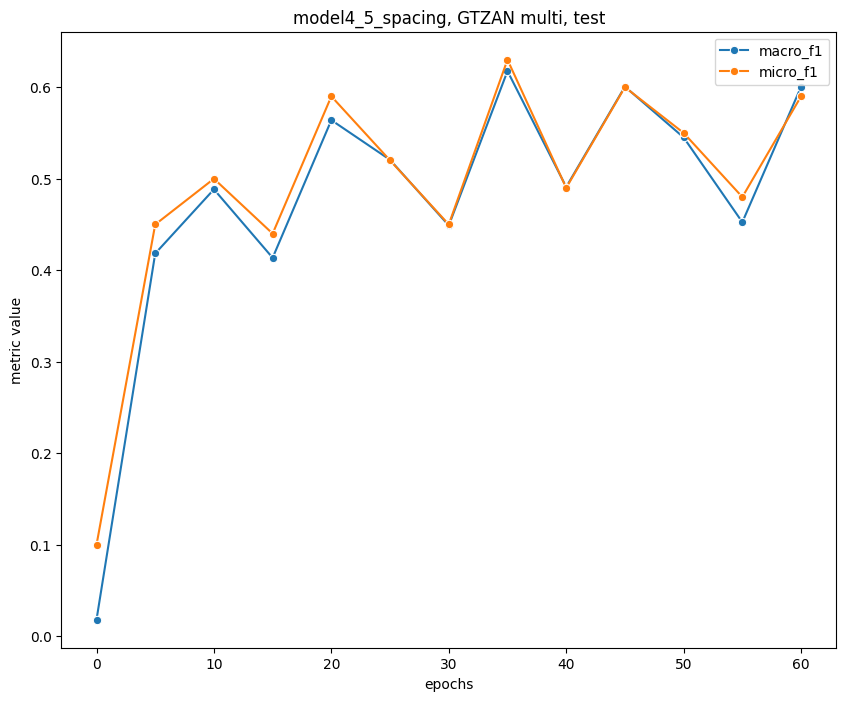

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.18089999999999995 in epoch 25


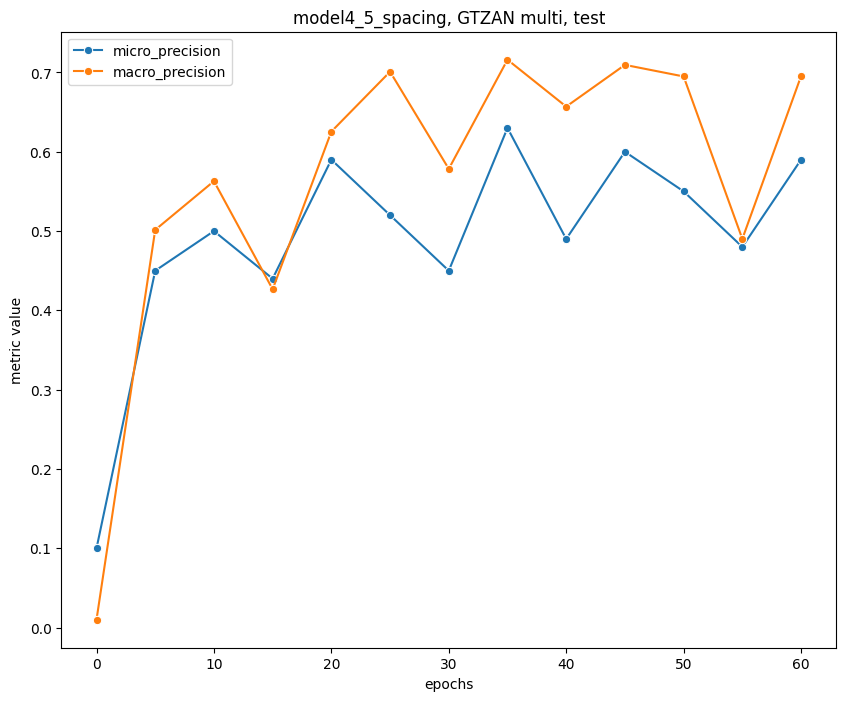

macro_recall is same as micro_recall in every epoch: True


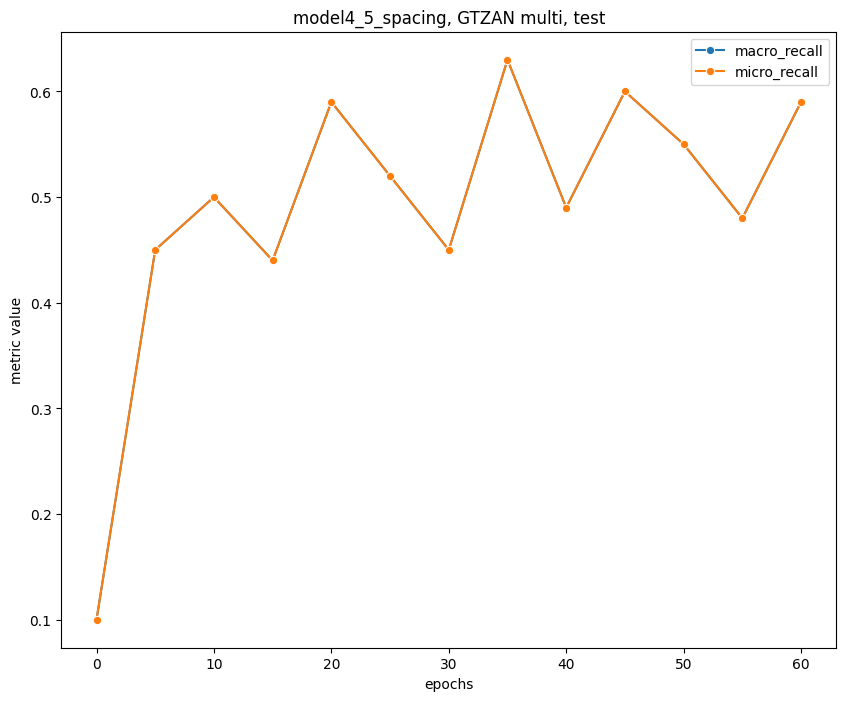

In [42]:
draw_figures_for_multi_model(base_dir=gtzan_multi_output_dir,
                             model_name='model4_5_spacing',
                             classes=gtzan_classes,
                             metrics=single_multi_metrics)

## Model5_10_spacing

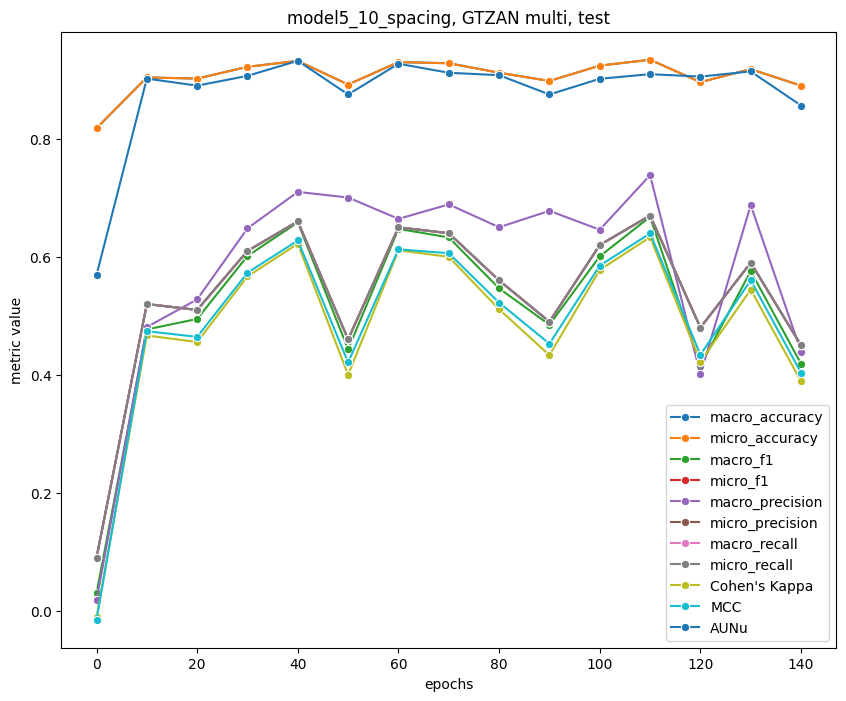

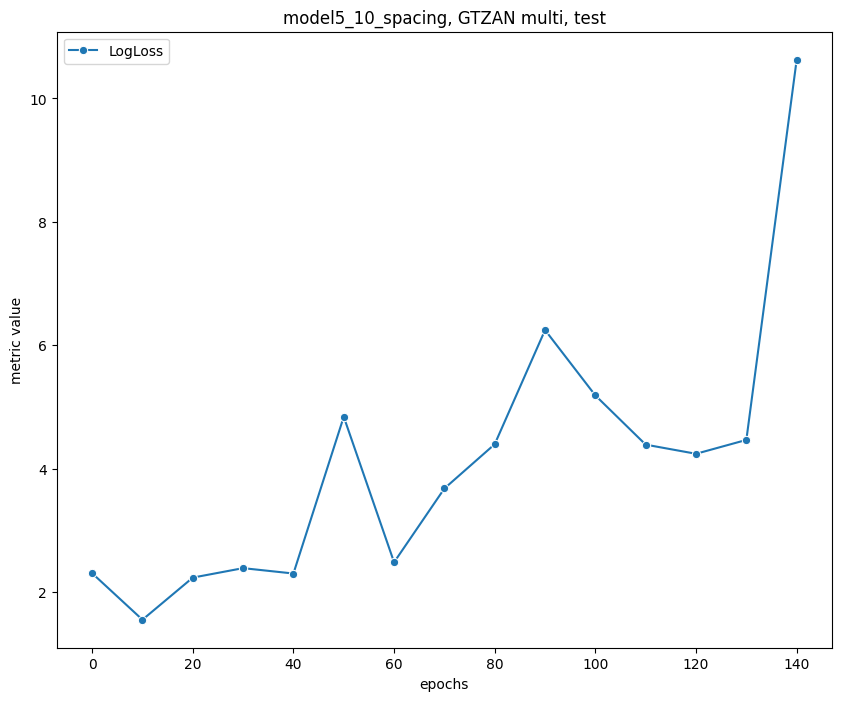

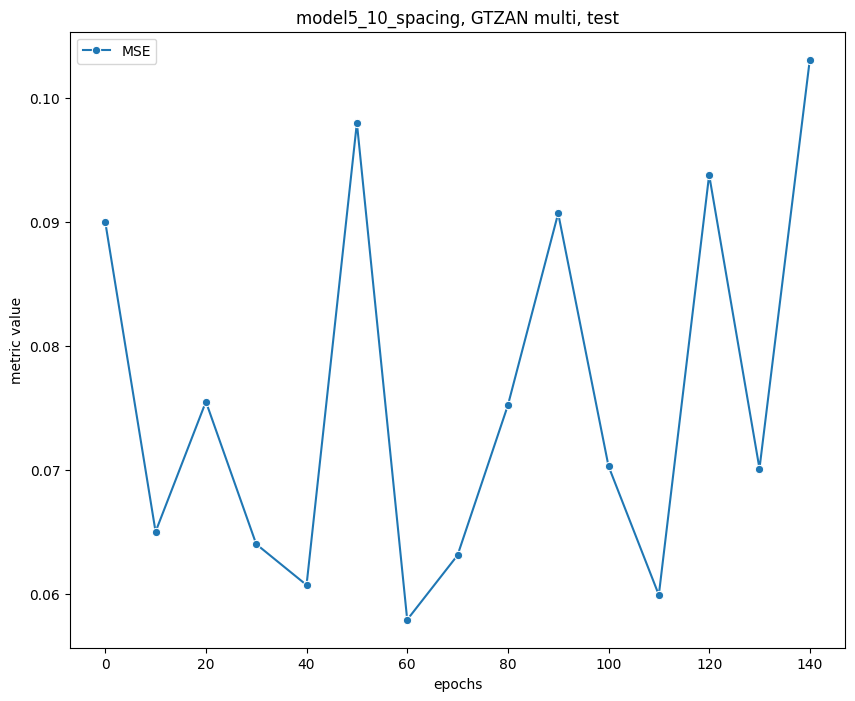

macro_accuracy is same as micro_accuracy in every epoch: True


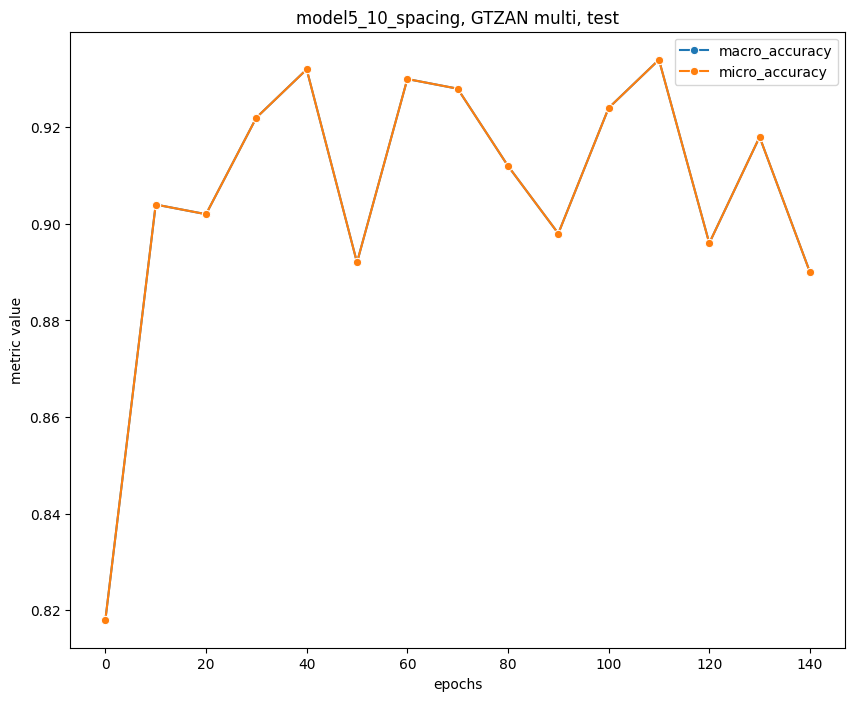

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.06439999999999996 in epoch 120


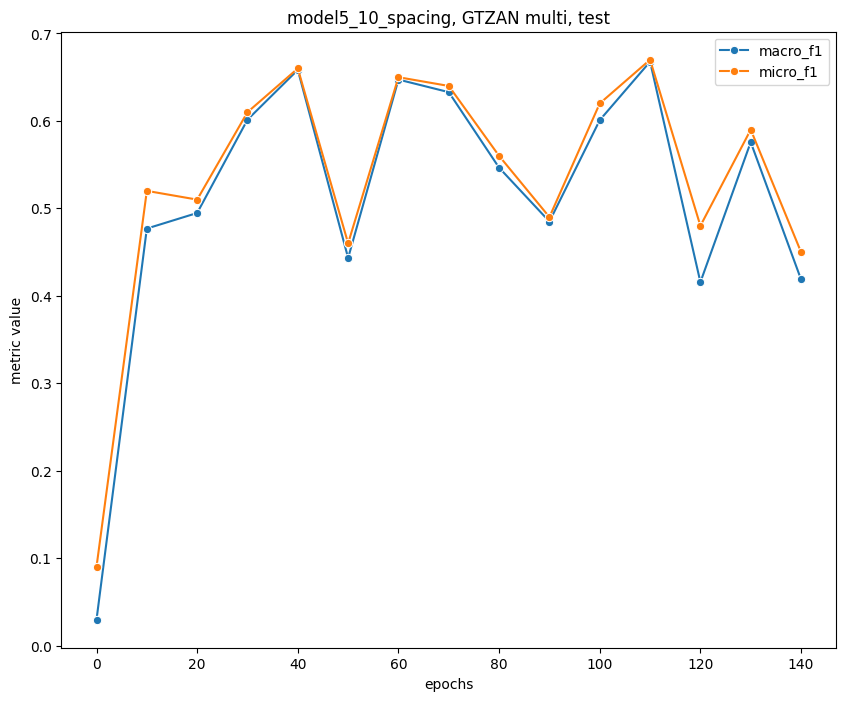

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.2405 in epoch 50


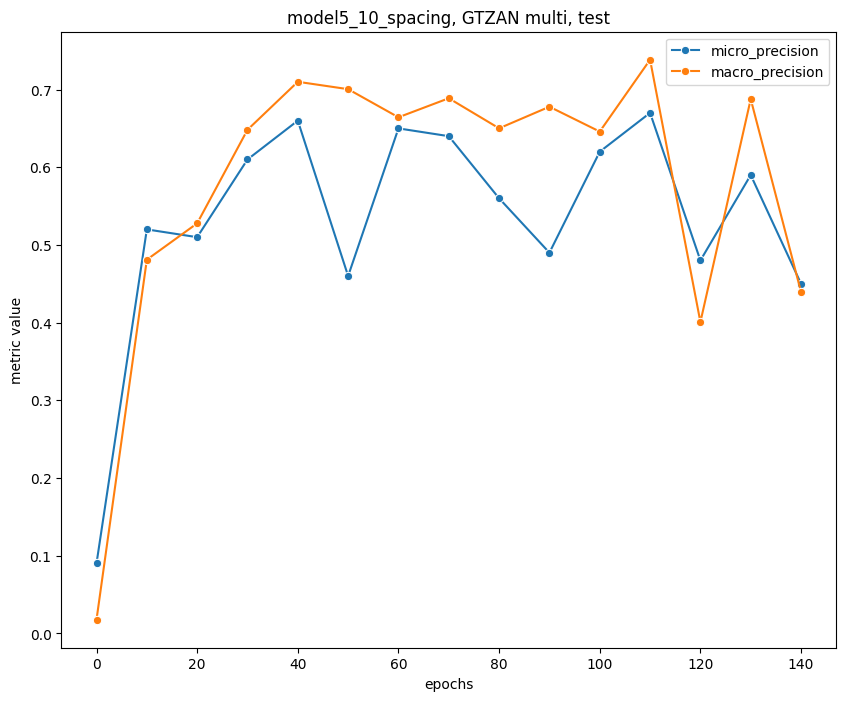

macro_recall is same as micro_recall in every epoch: True


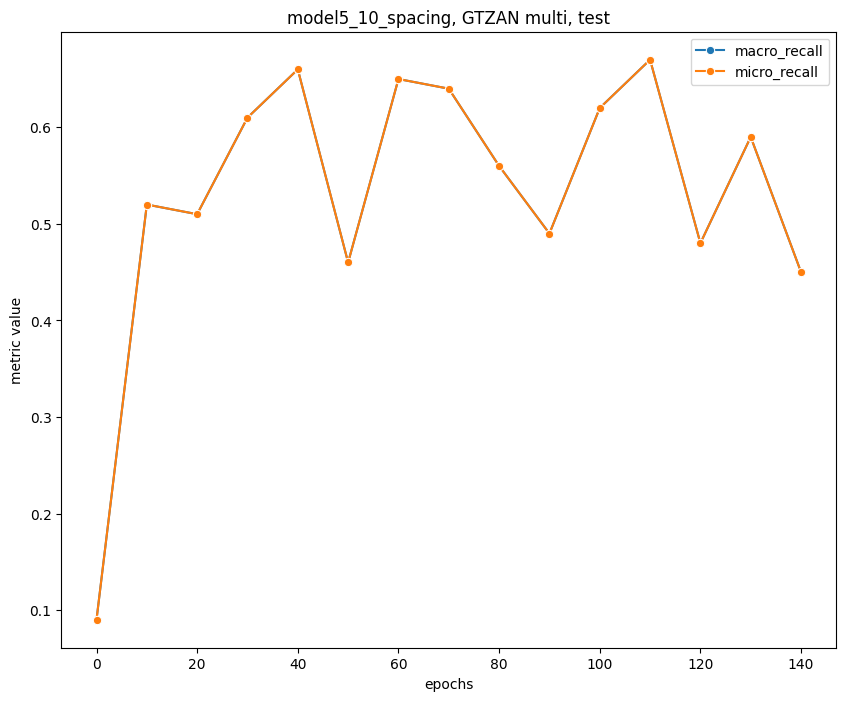

In [43]:
draw_figures_for_multi_model(base_dir=gtzan_multi_output_dir,
                             model_name='model5_10_spacing',
                             classes=gtzan_classes,
                             metrics=single_multi_metrics)

# FMA small multi

In [30]:
fma_small_multi_output_dir = report_output_dirs['fma_small_multi']

## model1_5_spacing

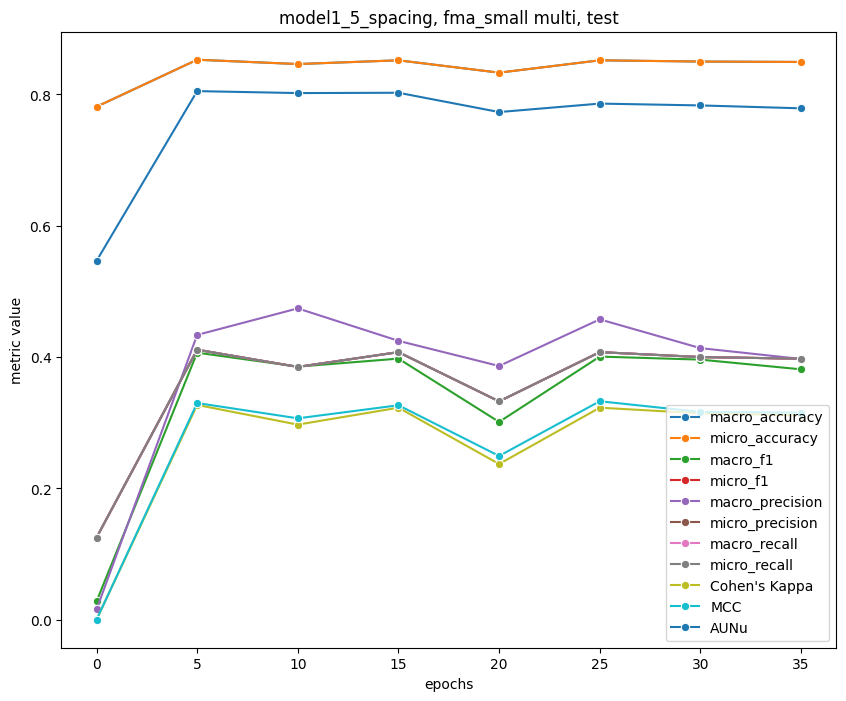

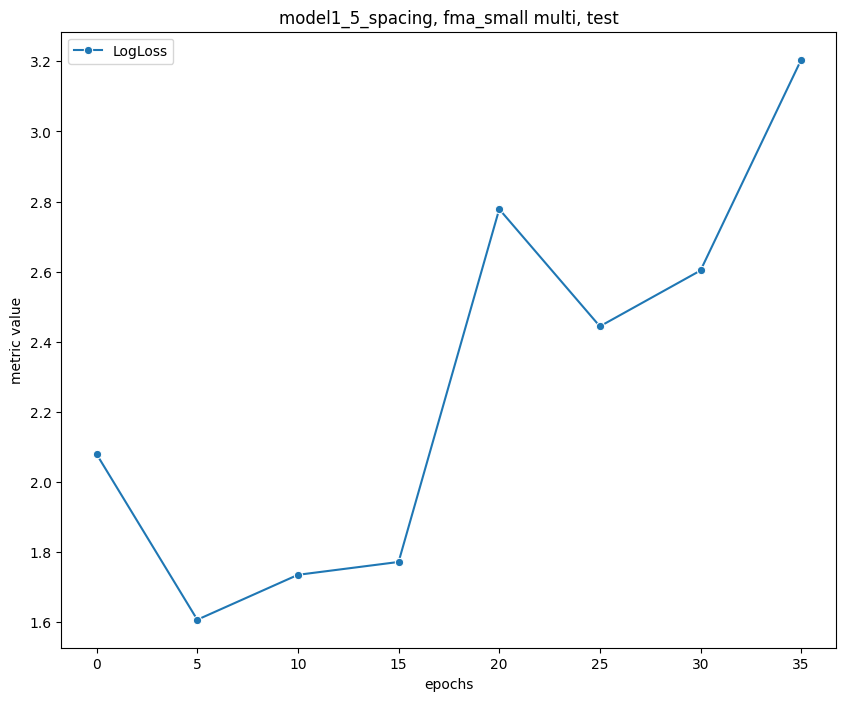

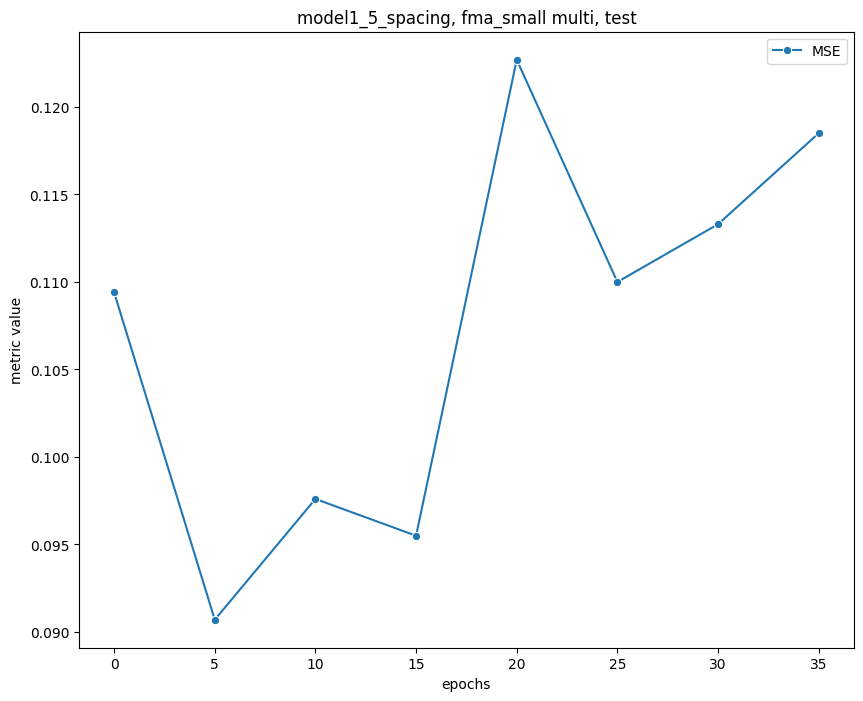

macro_accuracy is same as micro_accuracy in every epoch: True


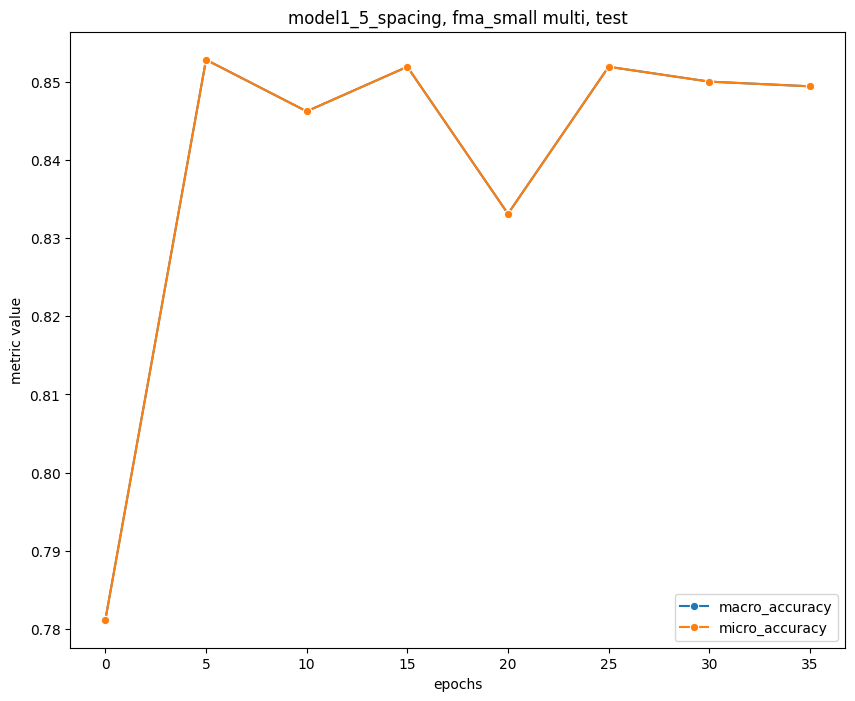

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09720000000000001 in epoch 0


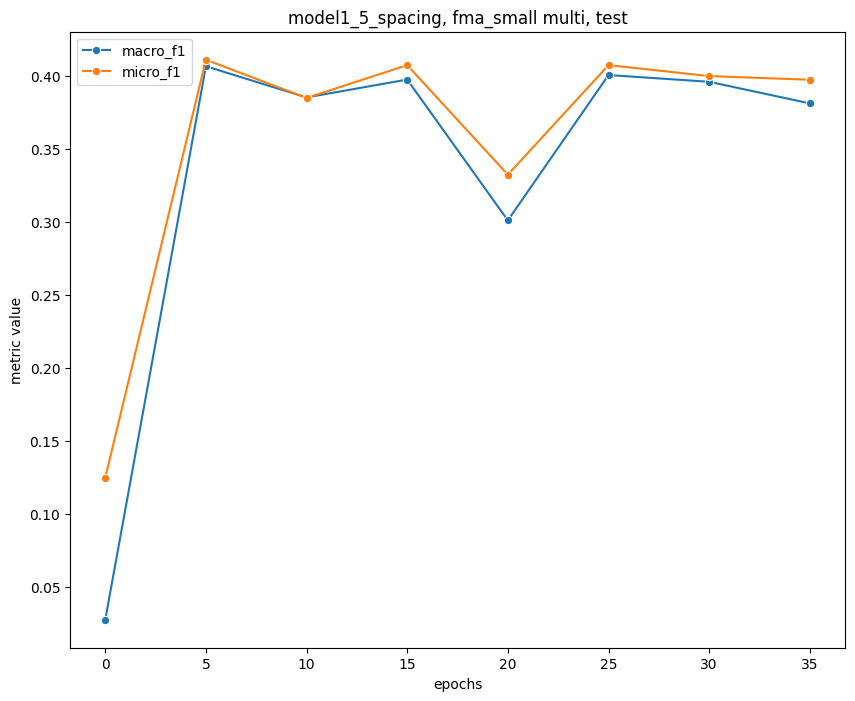

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.1094 in epoch 0


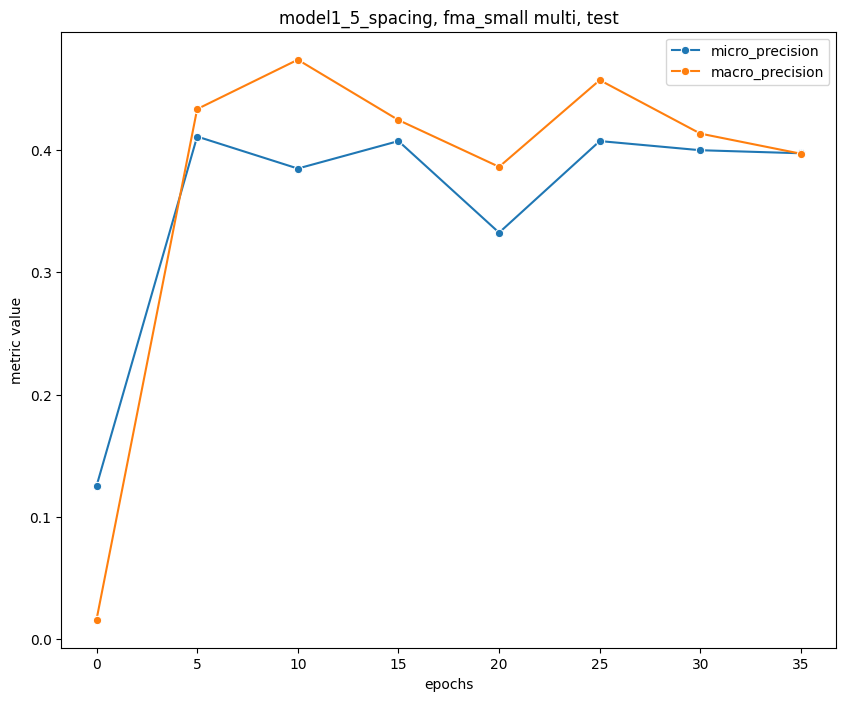

macro_recall is same as micro_recall in every epoch: True


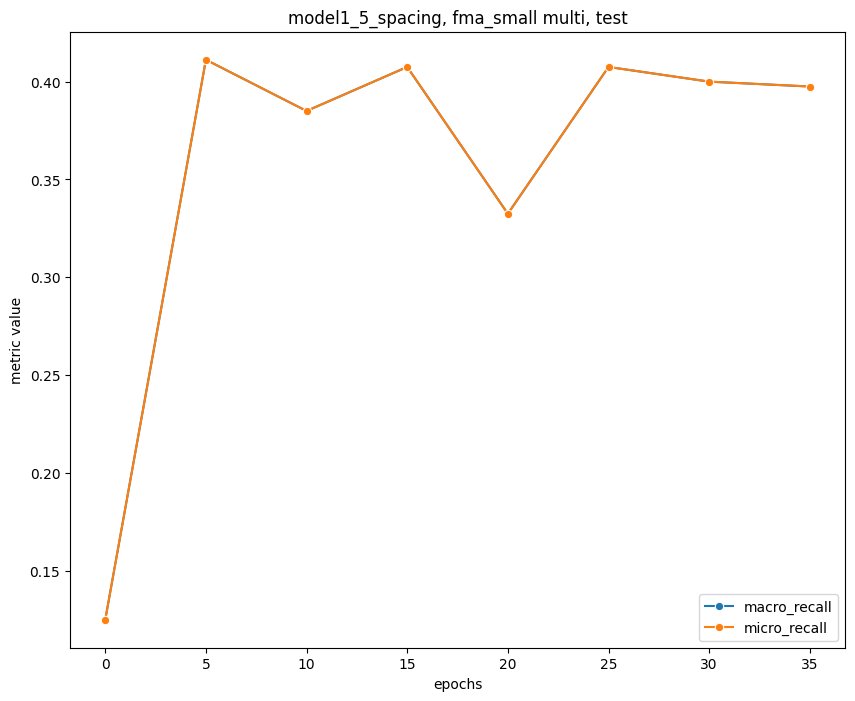

In [44]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model1_5_spacing',
                             classes=fma_small_top_classes,
                             metrics=single_multi_metrics)

## model2_10_spacing

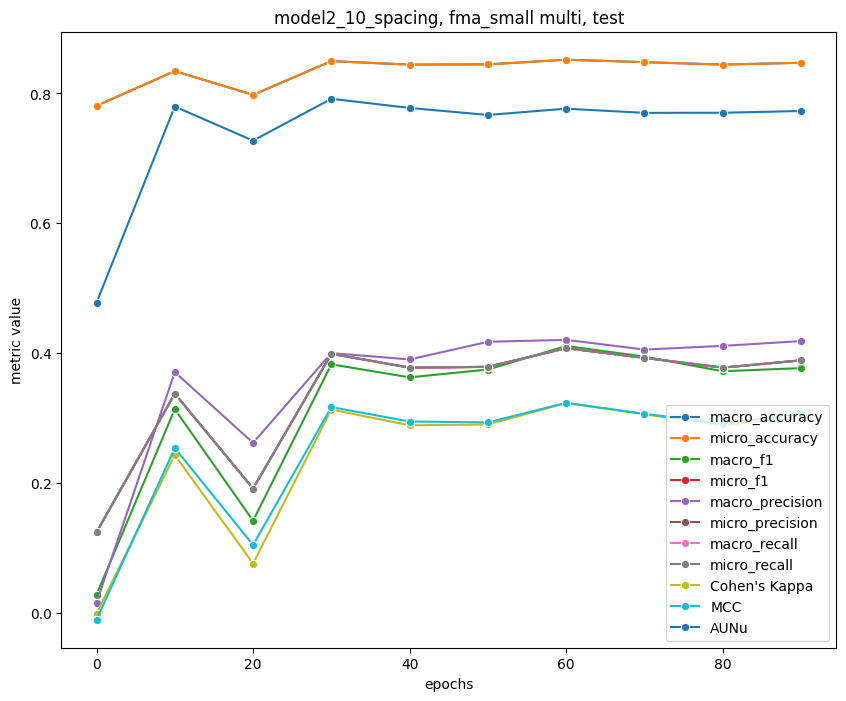

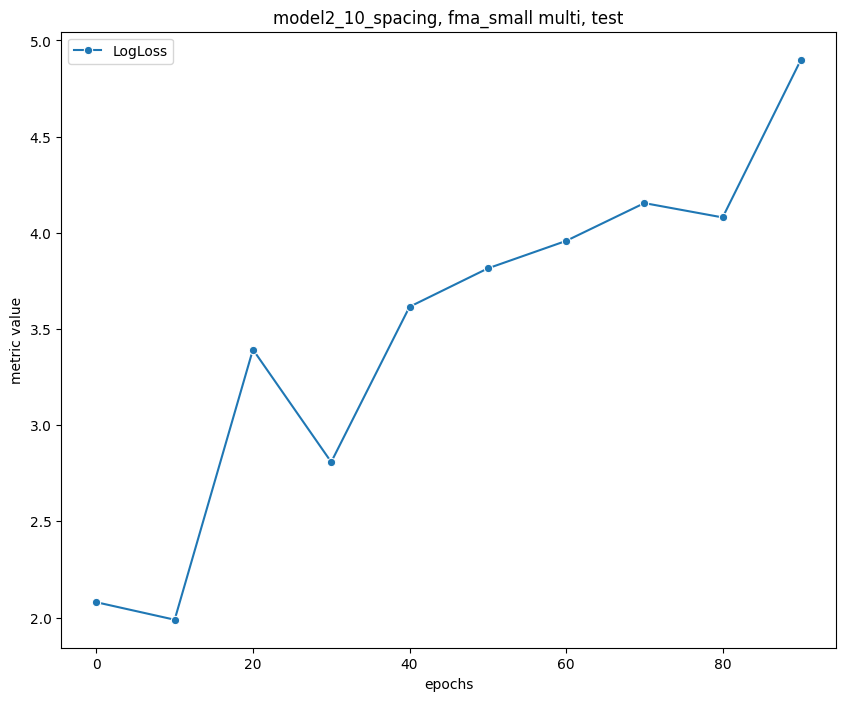

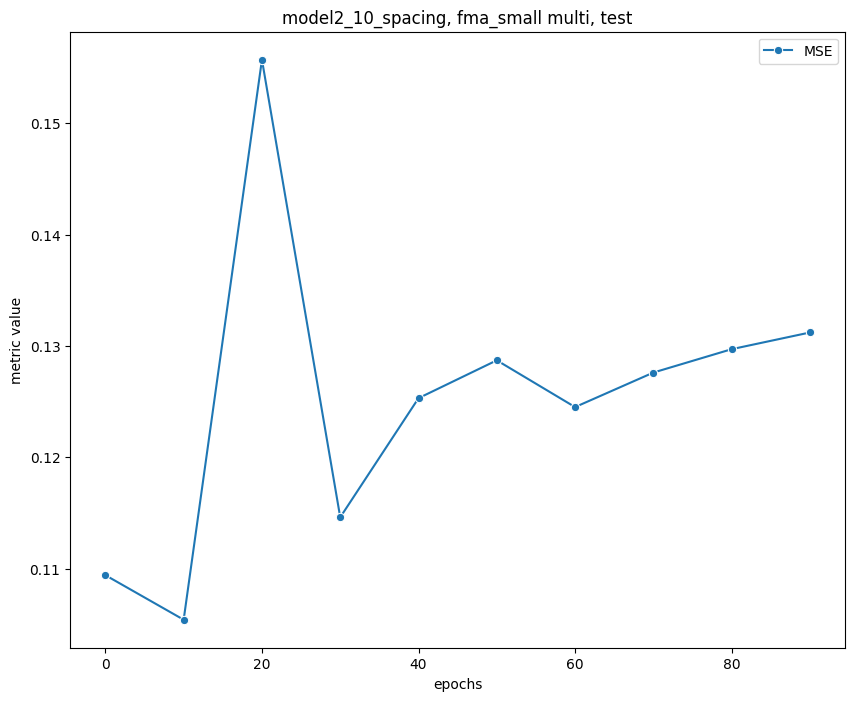

macro_accuracy is same as micro_accuracy in every epoch: True


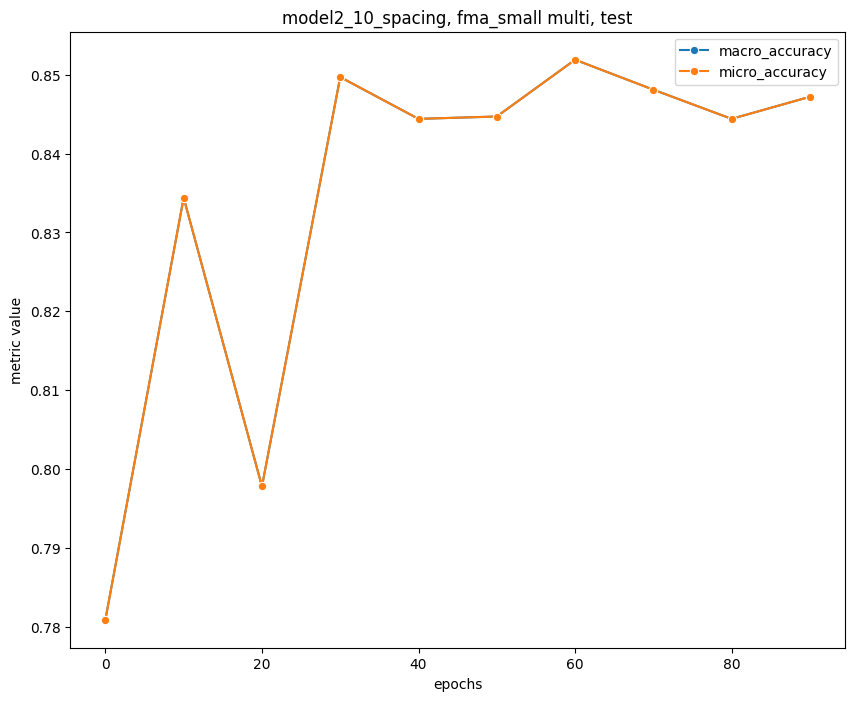

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09609999999999999 in epoch 0


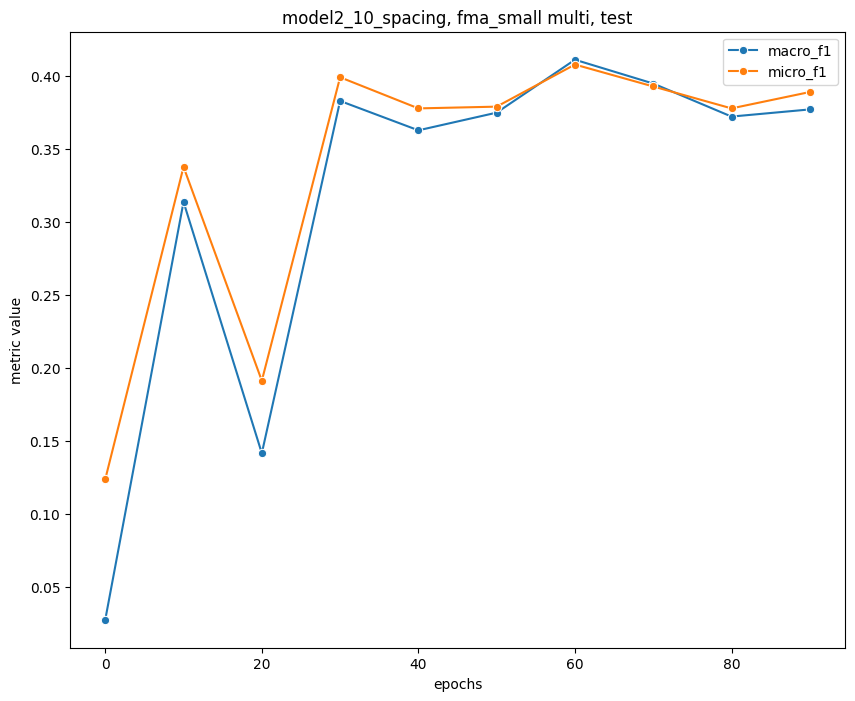

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.10819999999999999 in epoch 0


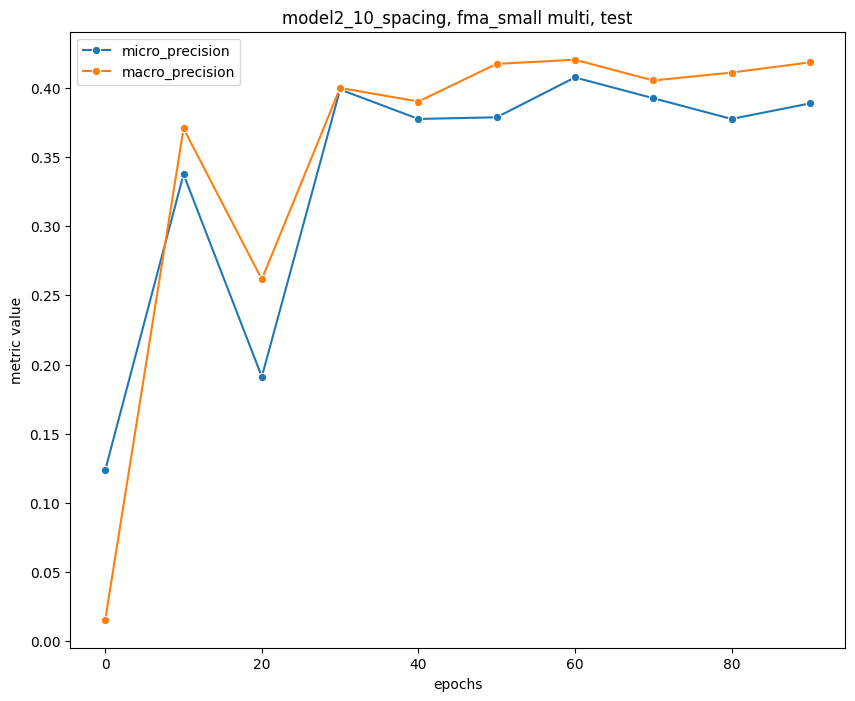

macro_recall is same as micro_recall in every epoch: False
Biggest difference: 9.999999999998899e-05 in epoch 90


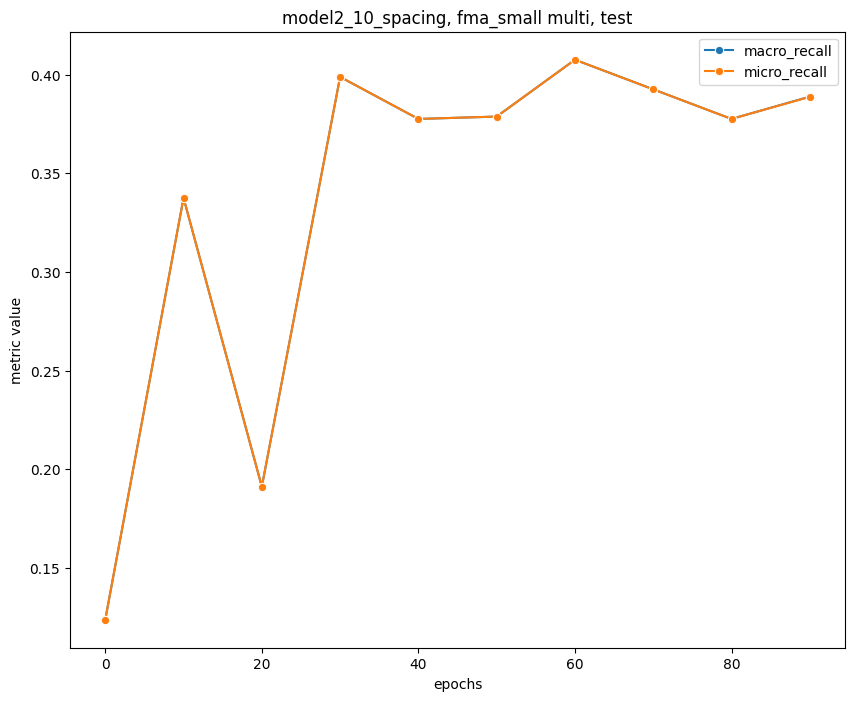

In [45]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model2_10_spacing',
                             classes=fma_small_top_classes,
                             metrics=single_multi_metrics)

## model3_10_spacing

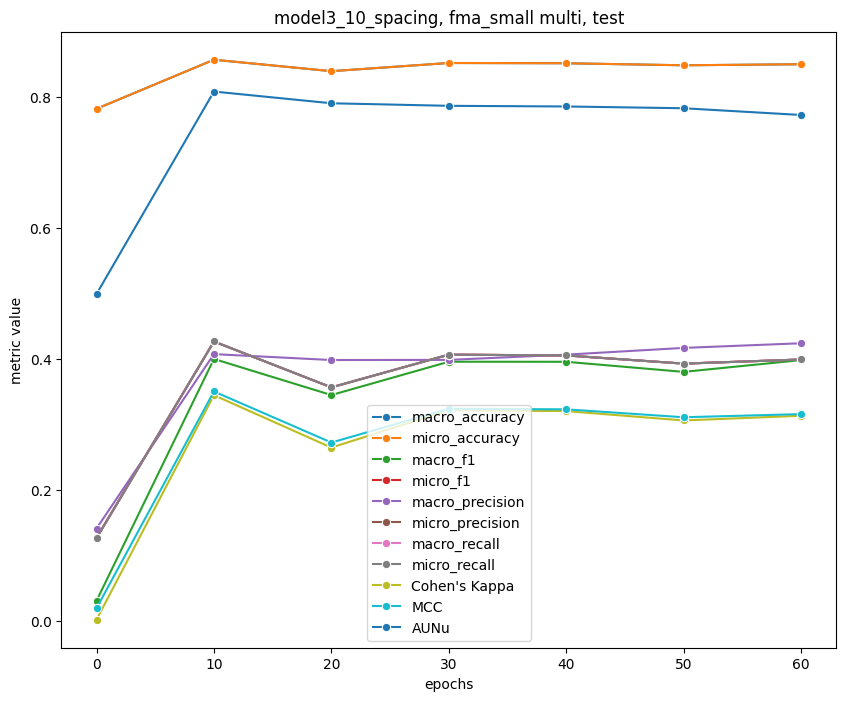

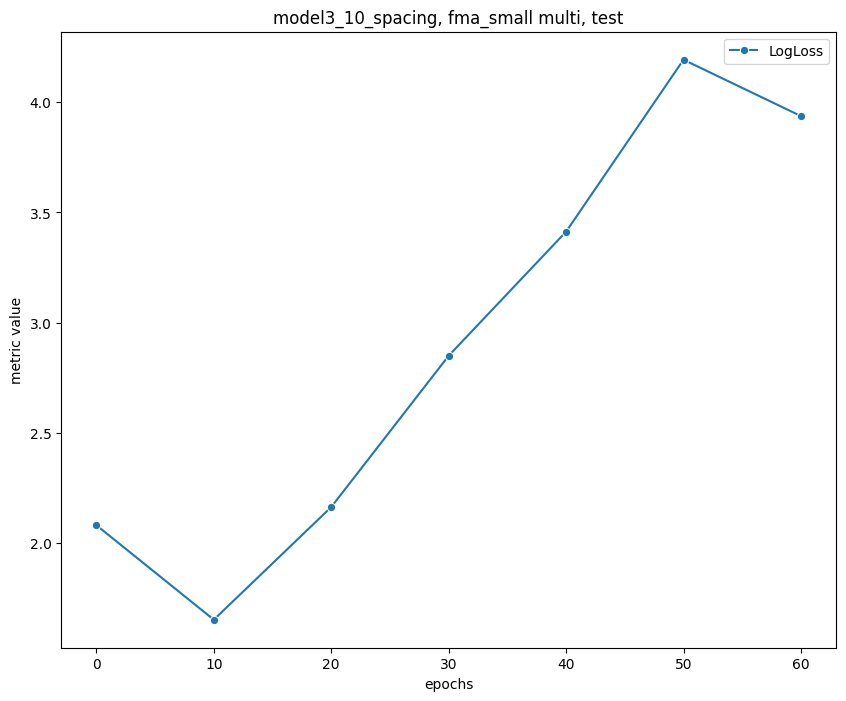

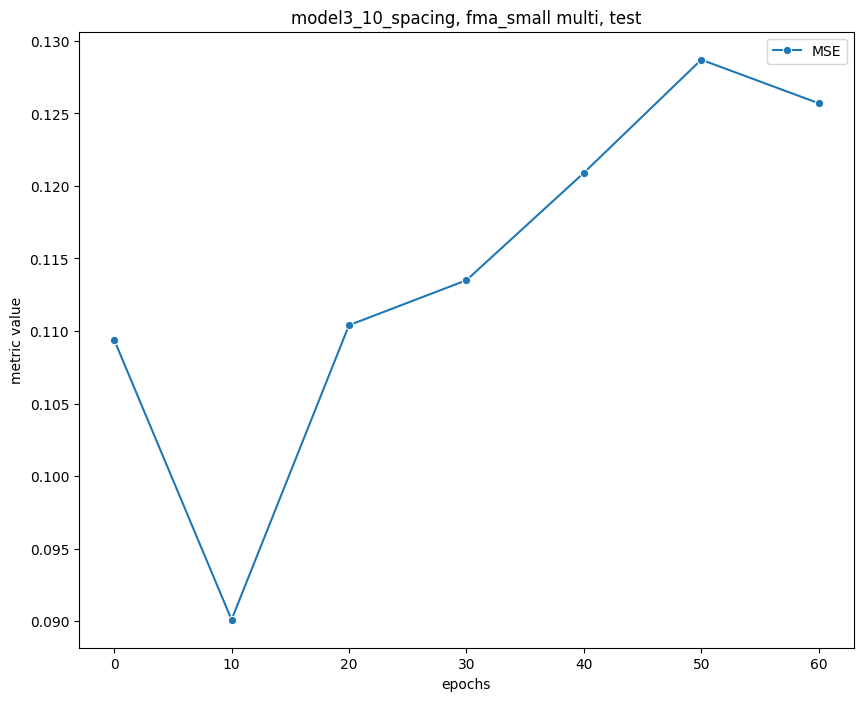

macro_accuracy is same as micro_accuracy in every epoch: True


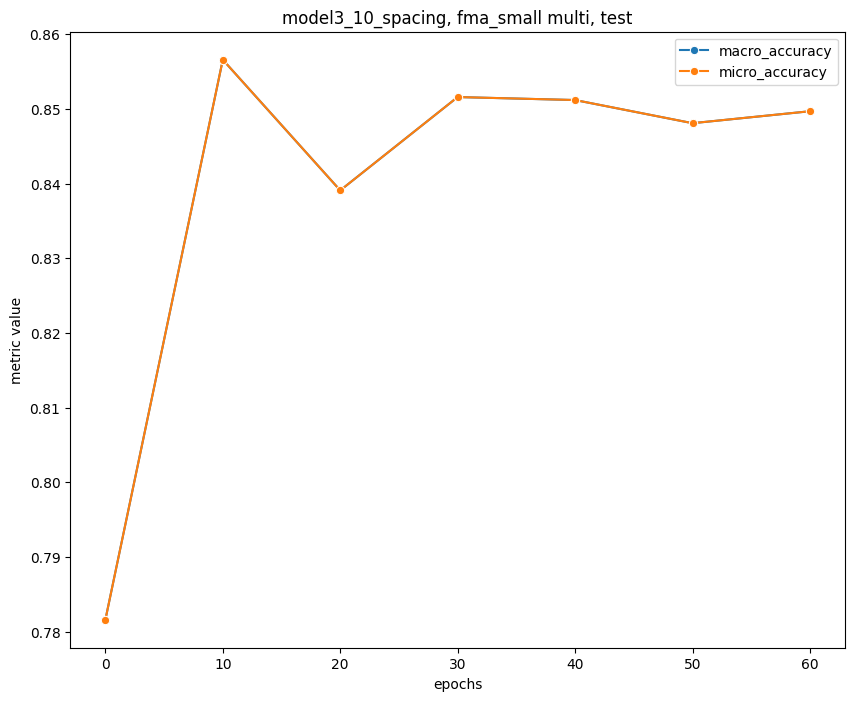

macro_f1 is same as micro_f1 in every epoch: False
Biggest difference: 0.09590000000000001 in epoch 0


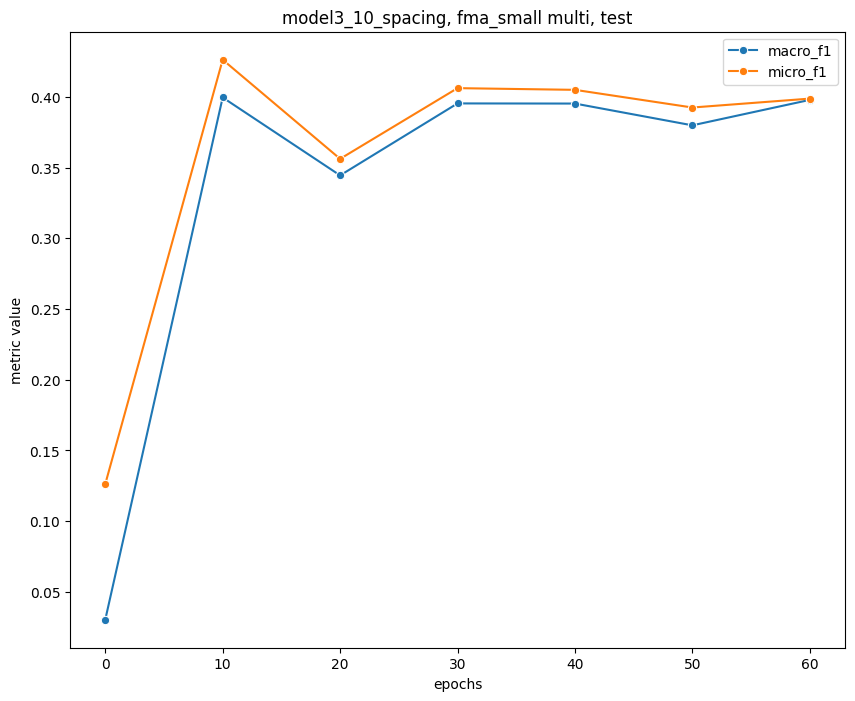

micro_precision is same as macro_precision in every epoch: False
Biggest difference: 0.041800000000000004 in epoch 20


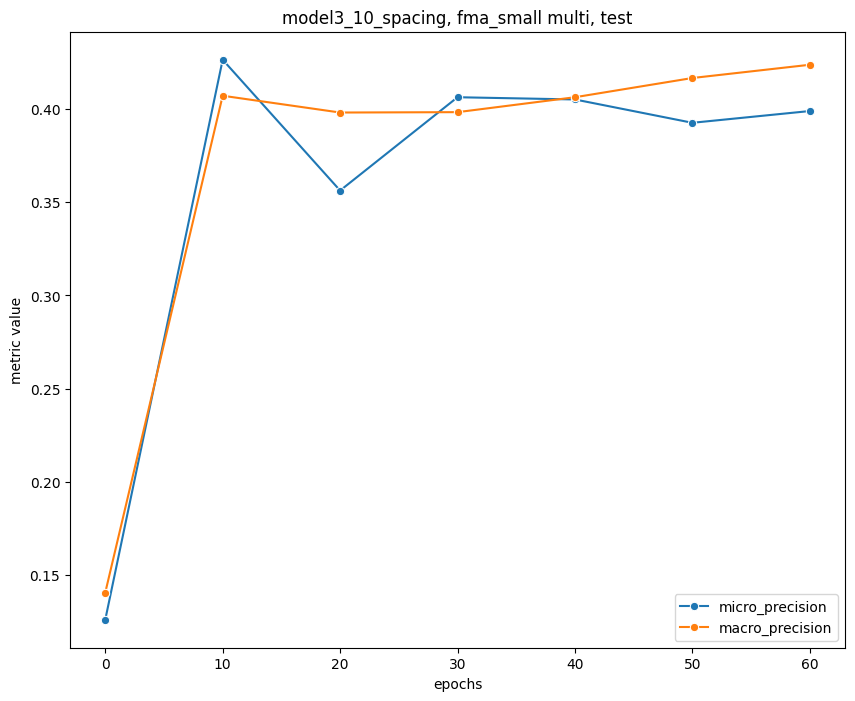

macro_recall is same as micro_recall in every epoch: True


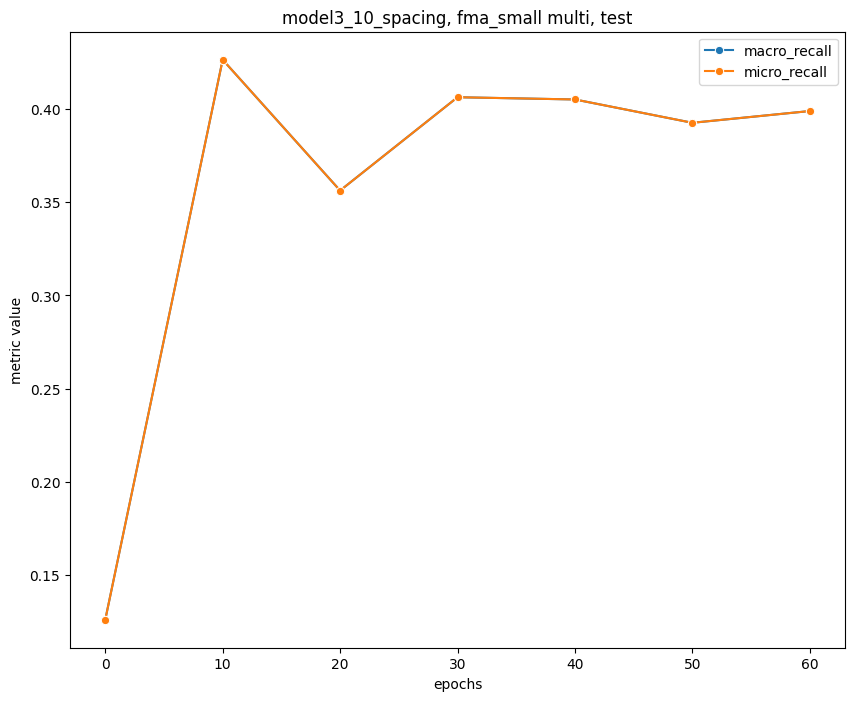

In [46]:
draw_figures_for_multi_model(base_dir=fma_small_multi_output_dir,
                             model_name='model3_10_spacing',
                             classes=fma_small_top_classes,
                             metrics=single_multi_metrics)

# FMA medium multi